# 利用 Amazon SageMaker XGBoost 算法預測分類

先設定參數。請使用自己的 S3 存貯體

In [1]:
!pip install -U imblearn

Requirement already up-to-date: imblearn in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (0.0)
Requirement not upgraded as not directly required: imbalanced-learn in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from imblearn) (0.4.3)
Requirement not upgraded as not directly required: scikit-learn>=0.20 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from imbalanced-learn->imblearn) (0.20.2)
Requirement not upgraded as not directly required: scipy>=0.13.3 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from imbalanced-learn->imblearn) (1.1.0)
Requirement not upgraded as not directly required: numpy>=1.8.2 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from imbalanced-learn->imblearn) (1.14.5)
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

bucket='pdm-sagemaker-dac43ec6047111e995b9d4619d3b01d6' # put your s3 bucket name here, and create s3 bucket
prefix = 'model'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3.{}.amazonaws.com/{}'.format(region, bucket)

CPU times: user 760 ms, sys: 178 ms, total: 939 ms
Wall time: 889 ms


### 獲取資料集

下列方法將分割資料集為訓練/驗證/測試資料集，並上傳檔案至 S3

In [10]:
%%time

import io
import boto3
import random

def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 15.3 µs


### 資料分割

兩種分割策略：
* 根據時間
* 根據機台 ID

根據時間分割較為複雜，因為訓練與測試資料集間，不能有重疊時間所計算的特徵。若 $X$ 為「特徵工程時使用的滾動窗的長度 - 1」的數值 ，測試/驗證資料集的序列中，時間剛好在 $X$ 之前的部分需要移除。

In [20]:
files = boto3.Session().resource('s3').Bucket(bucket).objects.all()

In [43]:
%%time
import pandas as pd

# Load the dataset
FILE_DATA = 'telemetry'
converters={"failure": str}
dfs= [pd.read_csv('s3a://{}/{}'.format(bucket, file_info.key), converters=converters) \
      for file_info in files if file_info.key.endswith('.csv') and not file_info.key.endswith('prediction-feature.csv')]
data = pd.concat(dfs, ignore_index=True).fillna('')

# split the downloaded data into train/test/validation files
FILE_TRAIN = '{}.train'.format(FILE_DATA)
FILE_VALIDATION = '{}.validation'.format(FILE_DATA)
FILE_TEST = '{}.test'.format(FILE_DATA)

CPU times: user 761 ms, sys: 16 ms, total: 777 ms
Wall time: 2.41 s


In [6]:
from sklearn.model_selection import train_test_split
lookback = 5       # rolling aggregation interval used during feature engineering
val_size = 0.2
test_size = 0.2
time_split = True  # if set to False, will perform asset ID-based split
seed=42

if time_split:
    data.set_index(['entryID'], inplace=True)
    data.sort_index(inplace=True)
    
    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    train, val = train_test_split(train, test_size=val_size/(1-test_size), shuffle=False)
    
    min_cycles = val.reset_index().groupby(['machineID'])\
                .cycle.min().apply(lambda x: x - lookback).to_frame(name='max_cycle')
    
    t = train.reset_index().join(min_cycles, on='machineID')
    train = t[t.max_cycle.isna() |
              (t.cycle < t.max_cycle)].drop('max_cycle', axis=1)
    train.set_index(['entryID'], inplace=True)
else:
    # asset ID-based split
    unique_assets = data.reset_index().machineID.unique()
    train_assets, test_assets = train_test_split(
        unique_assets, test_size=test_size, random_state=seed)
    train_assets, val_assets = train_test_split(
        train_assets, test_size=val_size/(1-test_size), random_state=seed)
    train = data[data.machineID.isin(train_assets)]
    val = data[data.machineID.isin(val_assets)]
    test = data[data.machineID.isin(test_assets)]
    train.set_index(['entryID'], inplace=True)
    val.set_index(['entryID'], inplace=True)
    test.set_index(['entryID'], inplace=True)



In [7]:
from sklearn.datasets import dump_svmlight_file
def name_to_class(x):
    return {
        '': 0,
        'F1': 1,
        'F2': 2.
    }[x]

def data_split(df, output_filename):
    df = df.reset_index(drop = True)
    columns_to_drop = ['cycle', 'immediate_failure', 'rul', 'sequenceID', 'machineID']
    
    # y is label
    y = df['immediate_failure'].apply(name_to_class) 
    dummy = pd.get_dummies(df.drop(columns_to_drop, axis=1))
    mat = dummy.as_matrix()
    dump_svmlight_file(mat, y, output_filename)

    return (df.drop(columns_to_drop, axis=1),
            df['immediate_failure'].values)

X_train, Y_train = data_split(train, FILE_TRAIN)
X_val, Y_val = data_split(val, FILE_VALIDATION)
X_test, Y_test = data_split(test, FILE_TEST)


#upload the files to the S3 bucket
upload_to_s3(bucket, 'train', FILE_TRAIN)
upload_to_s3(bucket, 'validation', FILE_VALIDATION)
upload_to_s3(bucket, 'test', FILE_TEST)

Writing to s3://pdm-sagemaker-dac43ec6047111e995b9d4619d3b01d6/model/train/telemetry.train
Writing to s3://pdm-sagemaker-dac43ec6047111e995b9d4619d3b01d6/model/validation/telemetry.validation
Writing to s3://pdm-sagemaker-dac43ec6047111e995b9d4619d3b01d6/model/test/telemetry.test


### 修正資料不平衡問題

In [8]:
from collections import Counter
all_classes = Counter(Y_train)
majority_class = all_classes.most_common(1)
minority_classes = all_classes.most_common()[1:]

print('Majority class: ', majority_class)
print('Minority classes: ', minority_classes)

Majority class:  [('', 34468)]
Minority classes:  [('F1', 396), ('F2', 186)]



With class imbalance in data, performance of most standard learning algorithms is compromised, since they aim to minimize the overall error rate. For a data set with 99% negative and 1% positive examples, a model can be shown to have 99% accuracy by labeling all instances as negative. But the model will mis-classify all positive examples; so even if its accuracy is high, the algorithm is not a useful one.

Here, we will use the Synthetic Minority Over-sampling Technique (SMOTE) [[3]](#ref_3) to produce a more balanced training data set with at least 10% of positive examples. Note that over-sampling is not applied to the test data set.

In [9]:
from imblearn.over_sampling import SMOTE

minority_classes_size = sum([c[1] for c in minority_classes])
desired_minority_classes_size = Y_train.shape[0] * 0.1

scale = desired_minority_classes_size / minority_classes_size

ratio = None
if scale > 1:
    ratio = dict((c[0], int(c[1] * scale)) for c in minority_classes)

sm = SMOTE(ratio=ratio, random_state=seed)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
Counter(Y_train_res)

Counter({'': 34468, 'F1': 2384, 'F2': 1120})

In [11]:
Y_train_res_ = [name_to_class(x) for x in Y_train_res] 
dump_svmlight_file(X_train_res, Y_train_res_, FILE_TRAIN)
upload_to_s3(bucket, 'train', FILE_TRAIN)

Writing to s3://pdm-sagemaker-dac43ec6047111e995b9d4619d3b01d6/model/train/telemetry.train


## 訓練 XGBoost 模型

In [12]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [13]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'DEMO-xgboost-regression-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

#Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/" + prefix + "/single-xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 5
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "objective":"multi:softmax",
        "num_class":"3",
        "num_round":"50"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/train',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/validation',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ]
}


client = boto3.client('sagemaker')
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

Training job DEMO-xgboost-regression-2018-12-20-20-21-43
InProgress
InProgress
InProgress
Completed
CPU times: user 87.2 ms, sys: 11.8 ms, total: 99 ms
Wall time: 3min


## 模型評估

### 繪製評估指標：混淆矩阵, 精確度 召回率及 F1 score

In [15]:
from sagemaker.analytics import TrainingJobAnalytics

metric_name = 'validation:merror'
TrainingJobAnalytics(training_job_name=job_name, metric_names=[metric_name]).dataframe()

,metric_name,timestamp,value
0,validation:merror,0.0,0.007764


Download model from S3 for local evaluation
從 S3 下載訓練好的模型以在1p32u42j0 qu/6

In [262]:
model_key = '{}/single-xgboost/{}/output/model.tar.gz'.format(prefix,job_name)
boto3.Session().resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
!tar -zxvf model.tar.gz

xgboost-model


In [263]:
!pip install xgboost

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [264]:
model_file_path = 'xgboost-model'

In [22]:
import pickle as pkl
import xgboost
import numpy as np
clf = pkl.load(open(model_file_path, 'rb'))

Y_val_ = np.array([name_to_class(x) for x in Y_val])

dval = xgboost.DMatrix(FILE_VALIDATION)
Y_val_predictions_ = clf.predict(dval)

[20:43:00] 13266x10 matrix with 132660 entries loaded from telemetry.validation


In [23]:
def class_to_name(x):
    return {
        0: '',
        1: 'F1',
        2: 'F2',
    }[x]

Y_val_predictions = [class_to_name(x) for x in Y_val_predictions_]

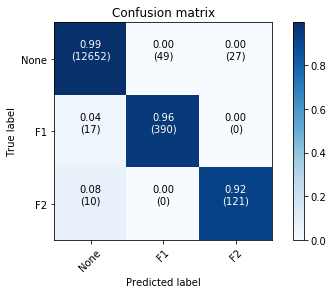

In [24]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    orig = cm
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt) + '\n({0})'.format(orig[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#cm = confusion_matrix(Y_test, binarizer.inverse_transform(Y_predictions))
cm = confusion_matrix(Y_val, Y_val_predictions)
plot_confusion_matrix(cm, ['None'] + [c[0] for c in minority_classes])

對二元分類任務，多數分類器的效能指標能直接從標準的 2x2 的混淆矩陣得到

$$
\begin{matrix} 
 & 預測=負 & 預測=正 \\
實際=負 & \scriptsize True\ 負\ (TN) & \scriptsize False\ 正 (FP) \\
實際=正 & \scriptsize False\ 負\ (FN) & \scriptsize True\ 正\ (TP) 
\end{matrix}
$$ 


這裡提供常用的模型效能測量指標定義

| 指標 | 公式 |
|:--- |------|
| 精準度 |   $\frac{TP}{TP+FP}$  |
| 召回率 | $\frac{TP}{TP+FN}$ |
| F1 score | $2 \frac{精準度 \cdot 召回率}{精準度+召回率}$ |

在多元分類問題，每個標註都會獨立計算以上指標，並以所有的類別做平均（如下所示）

In [25]:
print(classification_report(Y_val, Y_val_predictions, digits=4))

              precision    recall  f1-score   support

                 0.9979    0.9940    0.9959     12728
          F1     0.8884    0.9582    0.9220       407
          F2     0.8176    0.9237    0.8674       131

   micro avg     0.9922    0.9922    0.9922     13266
   macro avg     0.9013    0.9586    0.9284     13266
weighted avg     0.9927    0.9922    0.9924     13266



註: ```classification_report``` 函數計算平均時有將樣本分佈不平均考慮進去，因此會傾向往多樣本的類別偏移

### 準確率

一般而言，**準確率 (accuracy)** 對樣本分佈不平均的問題而言不是一個恰當的指標。以下範例展示，與每次都回傳最頻繁的出現的類別的 dummy 分類器比較：

In [26]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_res, Y_train_res)
Y_dummy = dummy.predict(X_val)

print('Accuracy scores')
print('Trained model: {0}\nDummy classifier: {1}'.format(accuracy_score(Y_val, Y_val_predictions),
                                                         accuracy_score(Y_val, Y_dummy)))

Accuracy scores
Trained model: 0.9922357907432534
Dummy classifier: 0.9594451982511684


訓練模型只比 dummy 分類器好一些些

### 曲線下面積 (AUC)

AUC 是*接收者操作特徵曲線*下的面積 (ROC 曲線)。AUC=1.0 表示完美的分類器，而 AUC=0.5表示該分類器與隨機猜選的效能一樣

In [27]:
from sklearn.preprocessing import LabelBinarizer
# roc_auc_score expects binarized labels
binarizer = LabelBinarizer()
binarizer.fit(Y_train_res)

def auc_score(y_true, y_pred):
    return roc_auc_score(binarizer.transform(y_true), binarizer.transform(y_pred), average='macro')

print('ROC AUC scores')
print('Trained model: {0}\nDummy classifier: {1}'.format(auc_score(Y_val, Y_val_predictions),
                                                         auc_score(Y_val, Y_dummy)))

ROC AUC scores
Trained model: 0.9699786636659544
Dummy classifier: 0.5


## 部署模型

### 將模型輸入到託管服務

In [28]:
%%time
import boto3
from time import gmtime, strftime

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

DEMO-xgboost-regression-2018-12-20-20-21-43-model
https://s3.us-east-2.amazonaws.com/pdm-sagemaker-dac43ec6047111e995b9d4619d3b01d6/model/single-xgboost/DEMO-xgboost-regression-2018-12-20-20-21-43/output/model.tar.gz
arn:aws:sagemaker:us-east-2:648352515148:model/demo-xgboost-regression-2018-12-20-20-21-43-model
CPU times: user 17.2 ms, sys: 3.83 ms, total: 21 ms
Wall time: 336 ms


### 建立端點配置

In [29]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2018-12-20-21-01-42
Endpoint Config Arn: arn:aws:sagemaker:us-east-2:648352515148:endpoint-config/demo-xgboostendpointconfig-2018-12-20-21-01-42


### 建立端點

In [30]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2018-12-20-21-01-56
arn:aws:sagemaker:us-east-2:648352515148:endpoint/demo-xgboostendpoint-2018-12-20-21-01-56
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-2:648352515148:endpoint/demo-xgboostendpoint-2018-12-20-21-01-56
Status: InService
CPU times: user 116 ms, sys: 6.41 ms, total: 122 ms
Wall time: 7min 1s


## 驗證模型正在服務中

In [31]:
runtime_client = boto3.client('runtime.sagemaker')

以單一筆資料做測試

In [32]:
!head -1 telemetry.test > telemetry.single.test

In [33]:
%%time
import json
from itertools import islice
import math
import struct

file_name = 'telemetry.single.test' #customize to your test file
with open(file_name, 'r') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/x-libsvm', 
                                   Body=payload)
result = response['Body'].read()
result = result.decode("utf-8")
result = result.split(',')
result = [math.ceil(float(i)) for i in result]
label = payload.strip(' ').split()[0]
print ('Label: ',label,'\nPrediction: ', result[0])

Label:  0 
Prediction:  0
CPU times: user 13.9 ms, sys: 0 ns, total: 13.9 ms
Wall time: 204 ms


做批次測試，以及計算整體準確度

In [34]:
import sys
import math
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    preds = [math.ceil(num) for num in preds]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [35]:
%%time
import json
import numpy as np

with open(FILE_TEST, 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
Y_test_predictions_ = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

Y_test_predictions = [class_to_name(x) for x in Y_test_predictions_]

.....................................................................................................................................CPU times: user 438 ms, sys: 30.8 ms, total: 469 ms
Wall time: 2.48 s


In [36]:
print('ROC AUC scores')
print('Test result: {0}\nValidation result: {1}'.format(auc_score(Y_test, Y_test_predictions),
                                                         auc_score(Y_val, Y_val_predictions)))

ROC AUC scores
Test result: 0.9674647056215225
Validation result: 0.9699786636659544


In [37]:
print('Accuracy scores')
print('Test result: {0}\nValidation result: {1}'.format(accuracy_score(Y_test, Y_test_predictions),
                                                         accuracy_score(Y_val, Y_val_predictions)))

Accuracy scores
Test result: 0.9879390924167044
Validation result: 0.9922357907432534


### 刪除端點
若以使用完端點，可以執行下列函數刪除端點

In [38]:
#client.delete_endpoint(EndpointName=endpoint_name)

## 將預測結果放入資料庫

In [290]:
dfs= [pd.read_csv('s3a://{}/{}'.format(bucket, file_info.key), converters=converters) \
      for file_info in files if file_info.key.endswith('features.csv')]
data_pred = pd.concat(dfs, ignore_index=True).fillna('')


In [292]:
FILE_DEMO = 'demo.prediction'
data_pred = data_pred.reset_index(drop = True)
drop_for_inference = ['cycle', 'MachineID', 'CycleStart', 'CycleEnd']

# y is label
mat = pd.get_dummies(data_pred.drop(columns_to_drop, axis=1)).as_matrix()
dump_svmlight_file(mat, np.ones(data_pred.shape[0]), FILE_DEMO)

p_X = data_pred.drop(drop_for_inference, axis=1)

In [293]:
with open(FILE_DEMO, 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
demo_data = [line for line in payload.split('\n')]
p_Y_predictions_ = batch_predict(demo_data, 100, endpoint_name, 'text/x-libsvm')

p_Y_predictions = [class_to_name(x) for x in p_Y_predictions_]

.

In [294]:
def name_to_class_v2(s):
    return {
        '': '正常',
        'F1': '異常狀況 1',
        'F2': '異常狀況 2'
    }[s]

In [295]:
latest_preds = []
for g in data_pred.groupby('MachineID'):
    latest_pred = g[1].sort_values('cycle', ascending=False).head(1).index[0]
    latest_preds.append(latest_pred)
    
def is_latest_pred(s):
    return '_' if s in latest_preds else '_INDEX_'

In [306]:
data_pred_ = data_pred.assign(PartitionKey=[is_latest_pred(x) for x in data_pred.index],
                              Prediction=[name_to_class_v2(x) for x in p_Y_predictions],
                              Timestamp=data_pred.CycleEnd.values,
                             RowKey=data_pred.MachineID.values,
                             MachineID=data_pred.MachineID.values)

In [307]:
data_pred_.head(1)

,MachineID,cycle,s1,s2,s3,s4,s5,s6,CycleStart,CycleEnd,s7,s8,s9,s10,PartitionKey,Prediction,Timestamp,RowKey
0,feat-4,5,1000.0,1103.334167,138.1063,138.24,1481.010067,1594.48,2018-12-21 02:53:03.752,2018-12-21 02:58:03.055,133.831306,138.151667,1404.15957,1594.445,_INDEX_,正常,2018-12-21 02:58:03.055,feat-4


In [273]:
import boto3
db_client = boto3.client('dynamodb')
table_name = 'predictions'
attributes = [  
        {'AttributeName':'PartitionKey', 'AttributeType':'S'},
        {'AttributeName':'Timestamp', 'AttributeType':'S'}
    ]
key_schema = [
    {'AttributeName':'PartitionKey', 'KeyType':'HASH'},
    {'AttributeName':'Timestamp', 'KeyType':'RANGE'}
]

if table_name not in db_client.list_tables()['TableNames']:
    db_client.create_table(
            TableName=table_name, 
            AttributeDefinitions=attributes,
            KeySchema=key_schema,
            BillingMode='PAY_PER_REQUEST'
        )
    time.sleep(3)
else:
    pass

while True:
    try:
        table_status = db_client.describe_table(TableName=table_name)['Table']['TableStatus']
        if table_status == 'ACTIVE':
            break
    except:
        time.sleep(1)


將預測結果放入 DynamoDB

In [304]:
for index, row in data_pred_.iterrows():
    entity = {
        'PartitionKey': {'S': str(row['PartitionKey'])},
        'Prediction': {'S': str(row['Prediction'])},
        'Timestamp': {'S': str(row['CycleEnd'])},
        'RowKey': {'S': str(row['RowKey'])},
        'MachineID': {'S': str(row['MachineID'])}
    }
    db_client.put_item(TableName=table_name, Item=entity)

將 cycle 資料放入 DynamoDB

In [308]:
import boto3
db_client = boto3.client('dynamodb')
CYCLE_TABLE = 'cycles'
attributes = [  
        {'AttributeName':'MachineID', 'AttributeType':'S'},
        {'AttributeName':'Timestamp', 'AttributeType':'S'}
    ]
key_schema = [
    {'AttributeName':'MachineID', 'KeyType':'HASH'},
    {'AttributeName':'Timestamp', 'KeyType':'RANGE'}
]

if CYCLE_TABLE not in db_client.list_tables()['TableNames']:
    db_client.create_table(
            TableName=CYCLE_TABLE, 
            AttributeDefinitions=attributes,
            KeySchema=key_schema,
            BillingMode='PAY_PER_REQUEST'
        )
    time.sleep(3)
else:
    pass

while True:
    try:
        table_status = db_client.describe_table(TableName=CYCLE_TABLE)['Table']['TableStatus']
        if table_status == 'ACTIVE':
            break
    except:
        time.sleep(1)


In [312]:
for index, row in data_pred_.iterrows():
    entity = {
        'MachineID': {'S': str(row['MachineID'])},
        'CycleStart': {'S': str(row['CycleStart'])},
        'Timestamp': {'S': str(row['CycleEnd'])},
        'SpeedDesiredMax': {'S': str(row['s1'])},
        'SpeedAvg': {'S': str(row['s2'])},
        'TemperatureAvg': {'S': str(row['s3'])},
        'TemperatureMax': {'S': str(row['s4'])},
        'PressureAvg': {'S': str(row['s5'])},
        'PressureMax': {'S': str(row['s6'])},
        'TemperatureAvgAvg': {'S': str(row['s7'])},
        'TemperatureMaxAvg': {'S': str(row['s8'])},
        'PressureAvgAvg': {'S': str(row['s9'])},
        'PressureAvgAvg': {'S': str(row['s10'])},
    }
    db_client.put_item(TableName=CYCLE_TABLE, Item=entity)